### Notebook Navigation

[__A.__ Question ](#section1)
<br />[__B.__ Brief Notes](#section2)
<br />[__C.__ Packages](#section3)
<br />[__D.__ Data Preparation](#section4)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__D1.__ Data Loading](#subsection4.1)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__D2.__ Data Preprocessing](#subsection4.2)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__D3.__ Visualising Data Points against Time](#subsection4.3)
<br />[__E.__ Stationarity Tests and Transformation](#section5)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__E1.__ Decomposition and Deseasonalisation](#subsection5.1)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__E2.__ Determining Percentage Change](#subsection5.2)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__E3.__ Augmented Dickey-Fuller (ADF) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test](#subsection5.3)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__E4.__ Differencing](#subsection5.4)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__E5.__ Second Stationarity Tests](#subsection5.5)
<br />[__F.__ Pre-Work for ARIMA Model](#section6)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__F1.__ Auto-Correlation Function (ACF) and Partial Auto-Correlation (PACF)](#subsection6.1)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__F2.__ Splitting into Train and Test sets](#subsection6.2)
<br />[__G.__ ARIMA Modelling](#section7)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__G1.__ Building the Model](#subsection7.1)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__G2.__ Evaluating the Model](#subsection7.2)
<br />[__H.__ Final Code](#section8)
<br />[__I.__ Alternative Modelling](#section9)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__I1.__ ARIMA Modelling on abs(Pct_change)](#subsection9.1)
<br />&ensp;&ensp;&ensp;&ensp;&ensp;[__I2.__ Simple Regression Model](#subsection9.2)

### Question <a id="section1"></a>

##### Goal: Develop a model to forecast South Korea's monthly Total Exports

##### Criteria: 
###### - Forecast should have at least 3 years (36 months of datapoints) of out of sample forecast. Rolling walk forward analysis is recommended to conserve data.

###### - We recommend using research papers as inspiration and a benchmark comparison.

###### - Following Occam's razor, the model should be explainable and any code should be easily read and run. 

###### - We recommend using Python but do not restrict the use of other languages.

###### - If using Python, please use Jupyter Notebook to include brief notes about your research consisting of an introduction, methodology (description of the model/strategy you are using, optimizations, limitations, etc.), findings with visualisations and key takeaways.	

##### Data Sources: https://www.ons.gov.uk/economy/nationalaccounts/balanceofpayments/timeseries/erdm/mret					


### Brief Notes<a id="section2"></a>

###### Please refer to Chin Jhin Tze_A0272883R_CHS_Y2_Documentation for Section 3 (attached in email) for my brief notes on my research

###### Else, you can access it here: https://docs.google.com/document/d/1r76r9IwoOlubudnw7lzABHMhtJntYrBg64U6wiaY-l4/edit?usp=sharing

### Packages<a id="section3"></a>

In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import joblib 
from pmdarima.arima import auto_arima
import warnings

### Data Preparation<a id="section4"></a>

##### Data Loading<a id="subsection4.1"></a>

In [11]:
# Load and Filter Data into dataframe
def load_data(filepath):
    data = pd.read_csv(filepath)
    data.columns = ['Time Period', 'Value'] # naming columns of dataframe
    pattern = re.compile(r'^\d{4}\s+[A-Za-z]{3}$') # defining regular expression pattern to filter out desired data 
    data = data[data['Time Period'].apply(lambda x: bool(pattern.match(x)))] # filtering out desired data points
    data['Time Period'] = pd.to_datetime(data['Time Period'], format='%Y %b') # converting format of date
    data.set_index('Time Period', inplace=True) # setting date of data as index of data frame
    return data

In [12]:
data = load_data('series-270724.csv')
print(data)

            Value
Time Period      
1997-01-01    109
1997-02-01     98
1997-03-01     90
1997-04-01    101
1997-05-01    118
...           ...
2024-01-01    290
2024-02-01    352
2024-03-01    329
2024-04-01    270
2024-05-01    532

[329 rows x 1 columns]


##### Data Preprocessing<a id="subsection4.2"></a>

In [14]:
# Pre-processing Data
def preprocess(data):
    data['Value'] = data['Value'].astype(float) # converting values to type float for further numerical data operations
    data.replace([np.inf, -np.inf, 0], np.nan, inplace=True) # checking for infinity, -infinity and zero values, and replace them with nan
    data.ffill(inplace=True) # replacing nan values using forward fill
    data.bfill(inplace=True) # replacing nan values using backward fill
    return data

In [15]:
data = preprocess(data)
print(data)

             Value
Time Period       
1997-01-01   109.0
1997-02-01    98.0
1997-03-01    90.0
1997-04-01   101.0
1997-05-01   118.0
...            ...
2024-01-01   290.0
2024-02-01   352.0
2024-03-01   329.0
2024-04-01   270.0
2024-05-01   532.0

[329 rows x 1 columns]


##### Visualising Data Points against Time<a id="subsection4.3"></a>

In [17]:
def visualise_timeseries(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Value'], label='Monthly Exports') # plotting Export Value against Date
    plt.xticks(data.index[::12],  rotation='vertical') # reducing number of ticks along x axis
    plt.xlabel('Date')
    plt.ylabel('Exports (in million USD)')
    plt.title('Trade in Goods: South Korea: Total: Exports: BOP: CP: SA')
    plt.legend()
    plt.show()

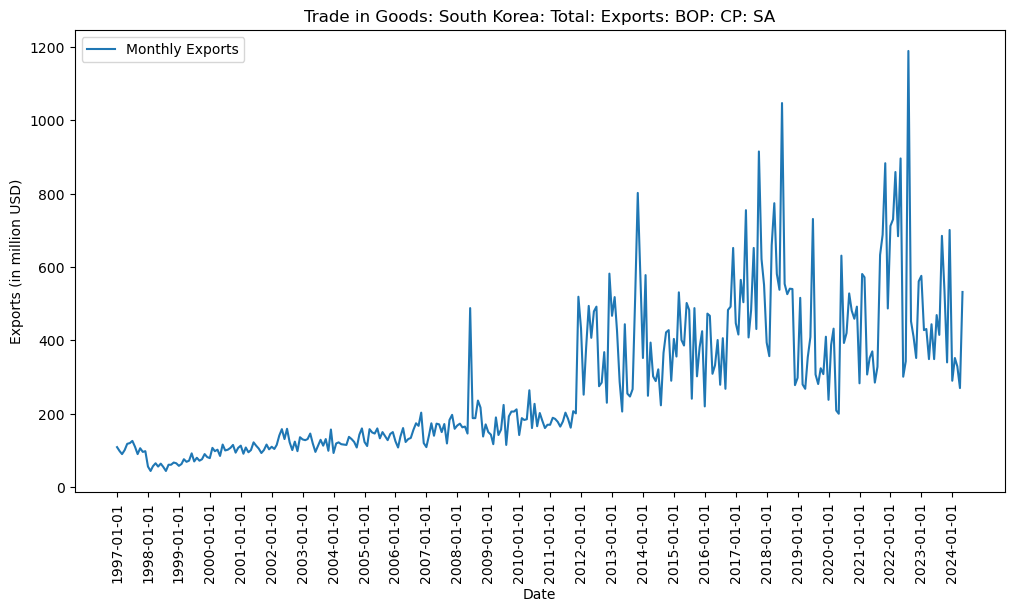

In [18]:
visualise_timeseries(data)

### Stationarity Tests and Transformation<a id="section5"></a>

##### Decomposition and Deseasonalisation<a id="subsection5.1"></a>

In [21]:
def decomposition(data):
    # Decomposing the time series into trend, seasonal and residual components
    decomposition = seasonal_decompose(data['Value'], model='multiplicative', period=12) # using multiplicative model to decompose time series
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plotting trend, seasonal and residual components of time series
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(data.index, data['Value'], label='Original')
    plt.legend(loc='best')
    
    plt.subplot(412)
    plt.plot(data.index, trend, label='Trend')
    plt.legend(loc='best')
    
    plt.subplot(413)
    plt.plot(data.index, seasonal, label='Seasonal')
    plt.legend(loc='best')
    
    plt.subplot(414)
    plt.plot(data.index, residual, label='Residual')
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

    # Plotting the seasonal component of the time series only
    plt.figure(figsize=(12, 8))
    plt.plot(seasonal, label='Seasonal Component')
    plt.title('Seasonal Component of South Korea\'s Trade in Goods Time Series')
    plt.xlabel('Date')
    plt.ylabel('Seasonal Component')
    plt.legend()
    plt.show()

    # Plotting the original time series data
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, data['Value'], label='Original Time Series', color='blue')

    # Plotting the original data without the seasonal component to show comparison
    deseasonalise = (data['Value'] / seasonal)
    plt.plot(deseasonalise, label='Original Data without Seasonal Component', color='green')
    plt.title('South Korea\'s Trade in Goods Time Series with and without Seasonal Component')
    plt.xlabel('Data')
    plt.ylabel('Exports (in million USD)')
    plt.legend()
    plt.show()
    
    return trend, seasonal, residual

In [22]:
def deseasonalise(data):
    decomposition = seasonal_decompose(data['Value'], model='multiplicative', period=12) # using multiplicative model to decompose time series
    deseasonalise = (data['Value'] / decomposition.seasonal) # deseasonalising values
    deseasonalised_df = pd.DataFrame(deseasonalise, columns=['Value']) # setting data into a dataframe
    return deseasonalised_df

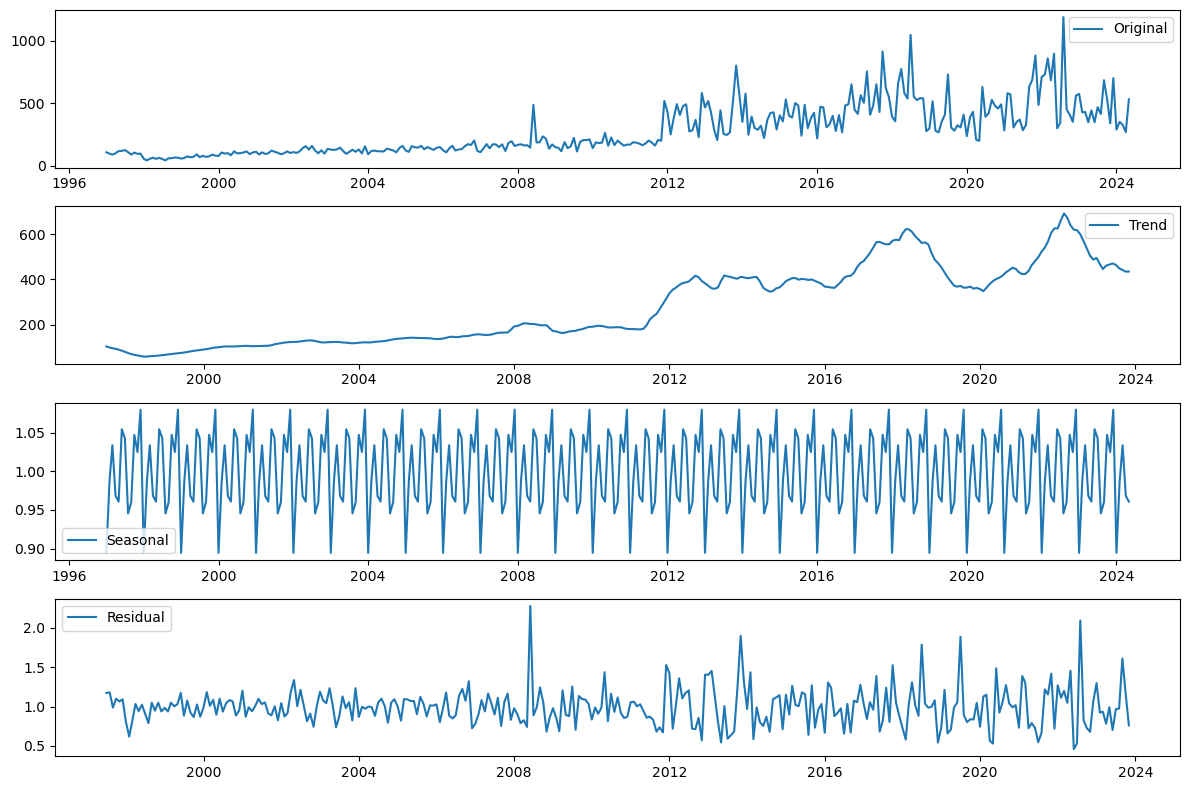

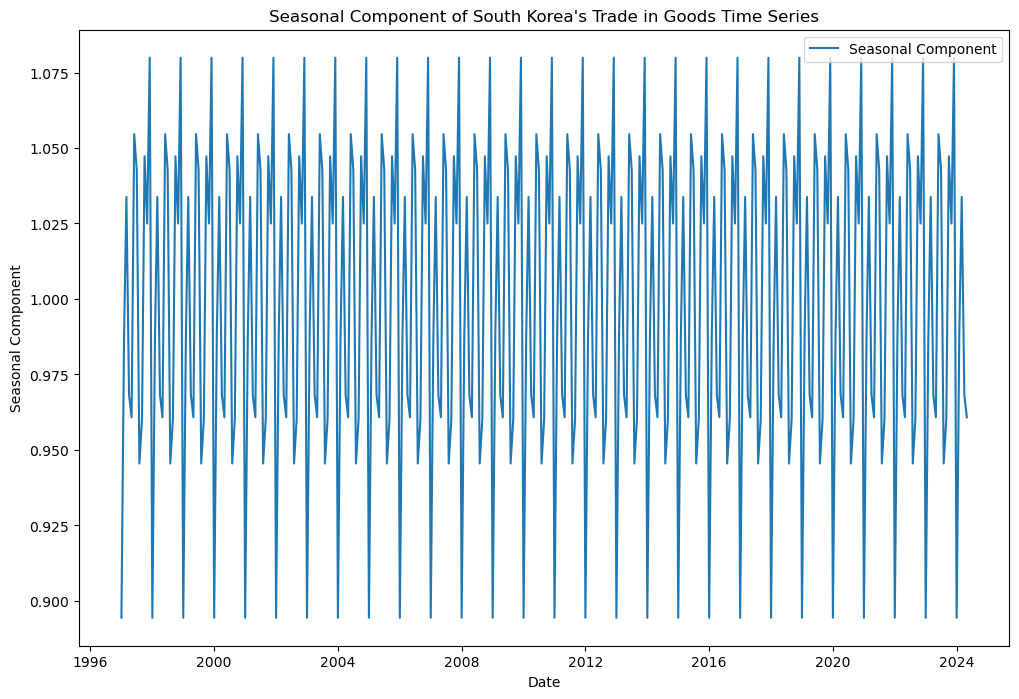

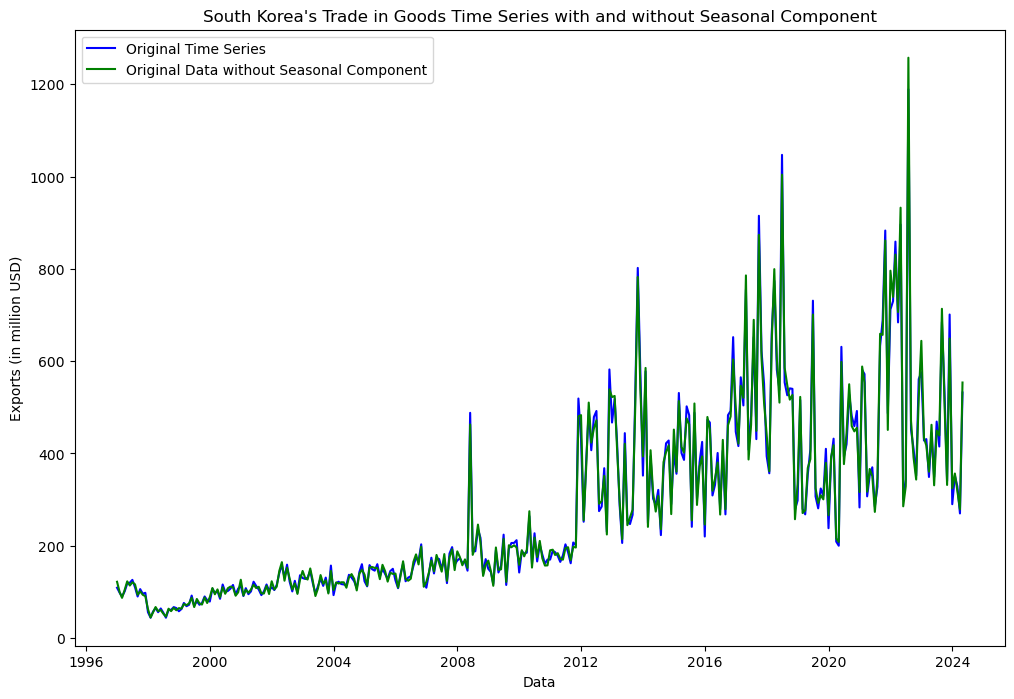

                  Value
Time Period            
1997-01-01   121.862383
1997-02-01    99.237113
1997-03-01    87.057439
1997-04-01   104.313516
1997-05-01   122.809699
...                 ...
2024-01-01   324.221019
2024-02-01   356.443507
2024-03-01   318.243305
2024-04-01   278.857914
2024-05-01   553.684404

[329 rows x 1 columns]


In [23]:
trend, seasonal, residual = decomposition(data)
df = deseasonalise(data)
print(df)

In [24]:
def decomposition_addictive(data):
    # Decomposing the time series into trend, seasonal and residual components
    decomposition = seasonal_decompose(data['Value'], model='addictive', period=12) # using multiplicative model to decompose time series
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plotting trend, seasonal and residual components of time series
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(data.index, data['Value'], label='Original')
    plt.legend(loc='best')
    
    plt.subplot(412)
    plt.plot(data.index, trend, label='Trend')
    plt.legend(loc='best')
    
    plt.subplot(413)
    plt.plot(data.index, seasonal, label='Seasonal')
    plt.legend(loc='best')
    
    plt.subplot(414)
    plt.plot(data.index, residual, label='Residual')
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

    # Plotting the seasonal component of the time series only
    plt.figure(figsize=(12, 8))
    plt.plot(seasonal, label='Seasonal Component')
    plt.title('Seasonal Component of South Korea\'s Trade in Goods Time Series')
    plt.xlabel('Date')
    plt.ylabel('Seasonal Component')
    plt.legend()
    plt.show()

    # Plotting the original time series data
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, data['Value'], label='Original Time Series', color='blue')

    # Plotting the original data without the seasonal component to show comparison
    deseasonalise = (data['Value'] / seasonal)
    plt.plot(deseasonalise, label='Original Data without Seasonal Component', color='green')
    plt.title('South Korea\'s Trade in Goods Time Series with and without Seasonal Component')
    plt.xlabel('Data')
    plt.ylabel('Exports (in million USD)')
    plt.legend()
    plt.show()
    
    return trend, seasonal, residual

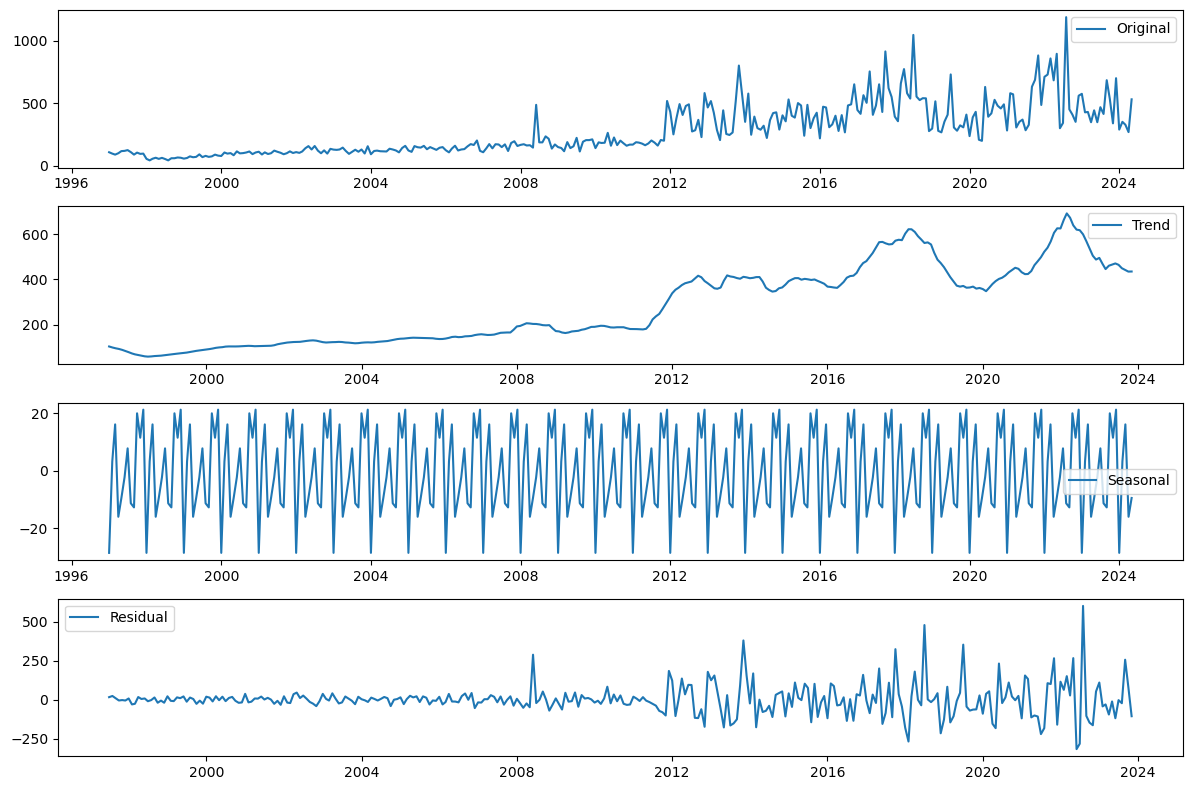

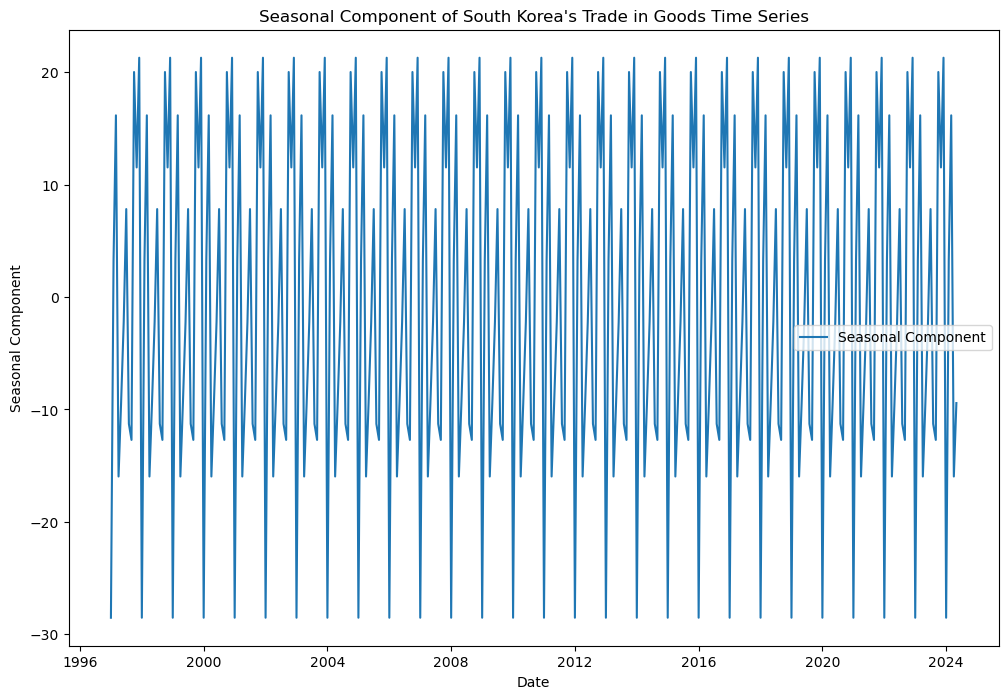

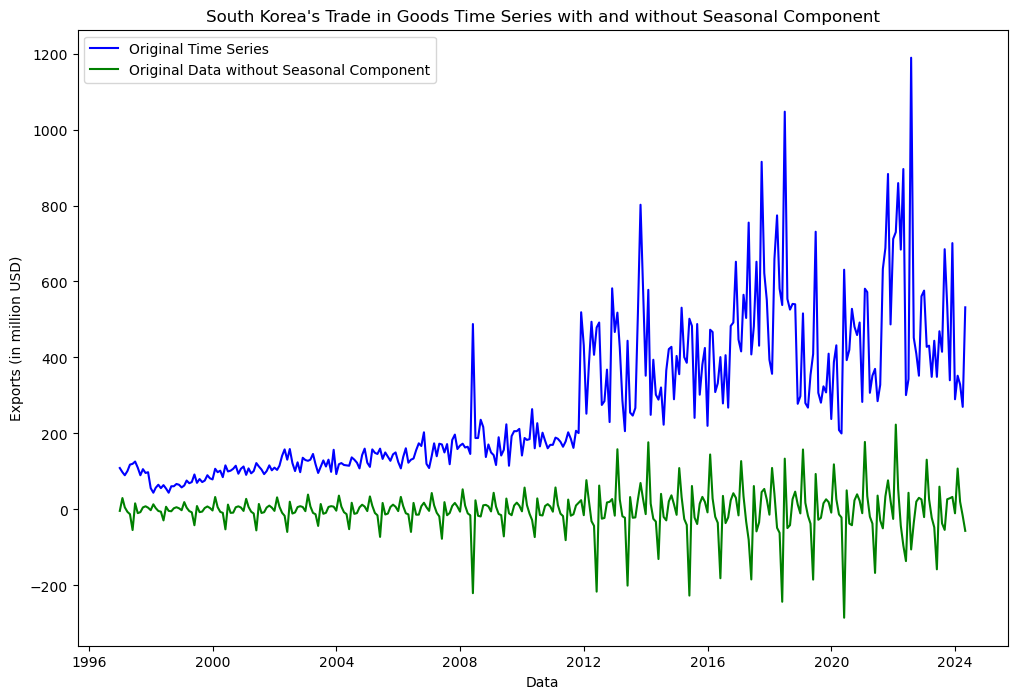

(Time Period
 1997-01-01   NaN
 1997-02-01   NaN
 1997-03-01   NaN
 1997-04-01   NaN
 1997-05-01   NaN
               ..
 2024-01-01   NaN
 2024-02-01   NaN
 2024-03-01   NaN
 2024-04-01   NaN
 2024-05-01   NaN
 Name: trend, Length: 329, dtype: float64,
 Time Period
 1997-01-01   -28.537398
 1997-02-01     3.270294
 1997-03-01    16.174140
 1997-04-01   -15.968488
 1997-05-01    -9.433231
                 ...    
 2024-01-01   -28.537398
 2024-02-01     3.270294
 2024-03-01    16.174140
 2024-04-01   -15.968488
 2024-05-01    -9.433231
 Name: seasonal, Length: 329, dtype: float64,
 Time Period
 1997-01-01   NaN
 1997-02-01   NaN
 1997-03-01   NaN
 1997-04-01   NaN
 1997-05-01   NaN
               ..
 2024-01-01   NaN
 2024-02-01   NaN
 2024-03-01   NaN
 2024-04-01   NaN
 2024-05-01   NaN
 Name: resid, Length: 329, dtype: float64)

In [25]:
decomposition_addictive(data)

##### Determining Percentage Change<a id="subsection5.2"></a>

In [27]:
def cal_percentage_change(data):
    data['Pct_change'] = data['Value'].pct_change()
    return data

In [28]:
df = cal_percentage_change(df)
print(df)

                  Value  Pct_change
Time Period                        
1997-01-01   121.862383         NaN
1997-02-01    99.237113   -0.185662
1997-03-01    87.057439   -0.122733
1997-04-01   104.313516    0.198215
1997-05-01   122.809699    0.177313
...                 ...         ...
2024-01-01   324.221019   -0.500535
2024-02-01   356.443507    0.099384
2024-03-01   318.243305   -0.107170
2024-04-01   278.857914   -0.123759
2024-05-01   553.684404    0.985543

[329 rows x 2 columns]


##### Augmented Dickey-Fuller (ADF) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test<a id="subsection5.3"></a>

In [30]:
def perform_stationarity_tests(data):
    # performing Augmented Dickey-Fuller (ADF) Test
    adf_result = adfuller(data.dropna())
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    for key, value in adf_result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')
        
    # performing Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test 
    warnings.filterwarnings("ignore")
    kpss_result = kpss(data.dropna(), regression='c')
    print('\nKPSS Statistic:', kpss_result[0])
    print('p-value:', kpss_result[1])
    for key, value in kpss_result[3].items():
        print('Critical Values:')
        print(f'   {key}, {value}')
    

In [31]:
perform_stationarity_tests(df['Pct_change'])

ADF Statistic: -12.190829111445796
p-value: 1.2869516713121955e-22
Critical Values:
   1%, -3.450695263332383
Critical Values:
   5%, -2.87050218926466
Critical Values:
   10%, -2.5715449066453284

KPSS Statistic: 1.0454362080799753
p-value: 0.01
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739


##### Differencing<a id="subsection5.4"></a>

In [33]:
def differencing(data):
    data['Pct_change_Diff'] = data['Pct_change'].diff().dropna() # calculating percentage change difference
    data = data.dropna() # dropping NaN values resulting from the differencing
    return data

In [34]:
df = differencing(df)
print(df)

                  Value  Pct_change  Pct_change_Diff
Time Period                                         
1997-03-01    87.057439   -0.122733         0.062929
1997-04-01   104.313516    0.198215         0.320948
1997-05-01   122.809699    0.177313        -0.020901
1997-06-01   113.790125   -0.073444        -0.250757
1997-07-01   120.832934    0.061893         0.135336
...                 ...         ...              ...
2024-01-01   324.221019   -0.500535        -1.457496
2024-02-01   356.443507    0.099384         0.599920
2024-03-01   318.243305   -0.107170        -0.206555
2024-04-01   278.857914   -0.123759        -0.016588
2024-05-01   553.684404    0.985543         1.109302

[327 rows x 3 columns]


##### Second Stationarity Tests<a id="subsection5.5"></a>

In [36]:
perform_stationarity_tests(df['Pct_change_Diff'])

ADF Statistic: -9.088554994428192
p-value: 3.8800657076006085e-15
Critical Values:
   1%, -3.451552879535732
Critical Values:
   5%, -2.8708786756338407
Critical Values:
   10%, -2.571745666091128

KPSS Statistic: 0.07922086727643882
p-value: 0.1
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739


### Pre-Work for ARIMA Model<a id="section6"></a>

##### Auto-Correlation Function and Partial Auto-Correlation<a id="subsection6.1"></a>

In [39]:
def plot_acf_pacf(data, lags=40):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    plot_acf(data, lags=lags, ax=ax[0])
    ax[0].set_title('Autocorrelation Function')
    
    plot_pacf(data, lags=lags, ax=ax[1])
    ax[1].set_title('Partial Autocorrelation Function')
    
    plt.show()

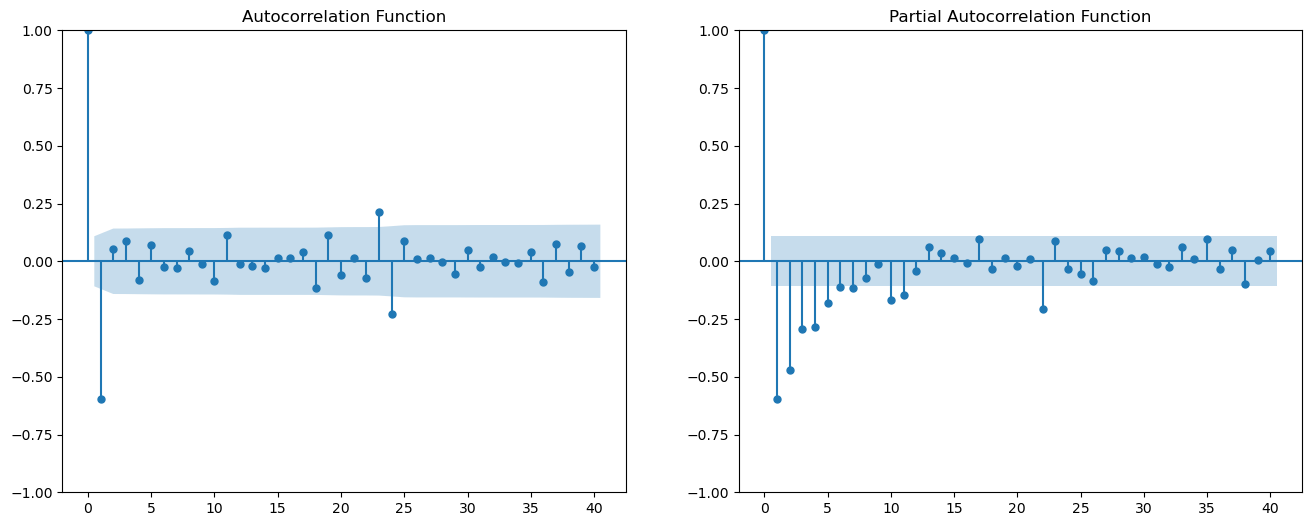

In [40]:
plot_acf_pacf(df['Pct_change_Diff'])

##### Splitting into Train and Test Sets<a id="subsection6.2"></a>

In [42]:
# Create dataframe for modelling based on pct_change_diff
model_data = df['Pct_change_Diff'].dropna()
model_data = model_data.to_frame(name = 'Pct_change_Diff')
model_data.index = pd.to_datetime(model_data.index)
model_data = model_data.asfreq('MS')
    
# Split into train and test sets
forecast_length = 36
X = model_data.values
n = forecast_length    
size = len(X) - n
train, test = X[0:size], X[size:len(X)]

In [43]:
print(model_data)
print(size, n, len(X))

             Pct_change_Diff
Time Period                 
1997-03-01          0.062929
1997-04-01          0.320948
1997-05-01         -0.020901
1997-06-01         -0.250757
1997-07-01          0.135336
...                      ...
2024-01-01         -1.457496
2024-02-01          0.599920
2024-03-01         -0.206555
2024-04-01         -0.016588
2024-05-01          1.109302

[327 rows x 1 columns]
291 36 327


### ARIMA Modelling<a id="section7"></a>

##### Building the Model<a id="subsection7.1"></a>

In [46]:
def build_arima_model(data,p,d,q):
    model = ARIMA(data, order=(p, d, q)) 
    model_fit = model.fit()
    return model_fit

def forecast_with_arima(model_fit, steps):
    forecast = model_fit.forecast(steps=steps)
    return forecast

def rolling_walk_forward(data, model_function, forecast_function, steps):
    predictions = []
    history = [x[0] for x in data]
    for t in range(steps):
        # using auto_arima to determine p,d,q for each time I forecast for the next month using ARIMA
        auto_model = auto_arima(history, start_p=1, start_q=1,
                      max_p=10, max_q=10,            
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
        p,d,q = auto_model.get_params().get("order")
        model_fit = model_function(history,p,d,q)
        forecast = forecast_function(model_fit, steps=1)
        predictions.append(forecast[0])
        history.append(forecast[0]) # adding forecast to history to prepare for next forecasting
        history.pop(0) # removing first month of history
    return predictions

In [47]:
arima_predictions = rolling_walk_forward(train, build_arima_model, forecast_with_arima, n)
print(arima_predictions)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=855.327, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=649.410, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=853.328, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=508.512, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=451.126, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=407.759, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=360.241, Time=0.05 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=346.133, Time=0.06 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=323.411, Time=0.10 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=309.258, Time=0.22 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=305.229, Time=0.18 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=303.447, Time=0.25 sec
 ARIMA(10,1,1)(0,0,0)[0] intercept   : AIC=221.894, Ti

In [48]:
# reverting pct_change_diff to pct_change
def revert_differencing(last_pct_change, pct_change_diffs):
    pct_changes = [last_pct_change]
    for diff in pct_change_diffs:
        pct_changes.append(pct_changes[-1] + diff)
    return pct_changes[1:]

# reverting pct_change to price form 
def revert_pct_change(last_value, pct_changes):
    original_values = [last_value]
    for pct in pct_changes:
        new_value = original_values[-1] * (1 + pct)
        original_values.append(new_value)
    return original_values[1:]

In [49]:
last_pct_change = df['Pct_change'].iloc[-n-1] # last known percentage change is at the 37th (-n-1) position from the back
pct_changes = revert_differencing(last_pct_change, arima_predictions) # obtaining value in pct change by reverting from pct change diff
print(pct_changes)
        
last_known_value = df['Value'].iloc[-n-1] # last known value inprice form  is at the 37th (-n-1) position from the back
price_form = revert_pct_change(last_known_value, pct_changes) # obtaining value in price form by reverting from pct change
print(price_form)
    
reseasonalised_forecast = price_form * seasonal[-n:] # obtaining value in reseasonalised price form by multiplying with seasonal component of those months
print(reseasonalised_forecast)

[-0.026049022289189927, 0.09310287027672681, 0.07253661964755337, -0.09492663964038972, 0.11534584563505473, 0.03038262820766713, -0.0010551269387211737, 0.13709929019393768, 0.003513708909583163, -0.024563407928352127, 0.07716424464058802, 0.014534660427857421, 0.05502218344199454, 0.03517099810117473, 0.014848395821396687, 0.06544018454769267, 0.027419471177928784, 0.030998081780561626, 0.05084350013752374, 0.017457390827517266, 0.03892328111783423, 0.044821412605659736, 0.028618987538414624, 0.043016306696084666, 0.03402764076474861, 0.034099950917308115, 0.042839128289460154, 0.032518063135596326, 0.03673687731228903, 0.03871717054513257, 0.03215137659658828, 0.03985970725837759, 0.036213923007545425, 0.03499689194395906, 0.037642622079825314, 0.03515506836753286]
[356.8045796494737, 390.02411014272064, 418.31514067351867, 378.6058900586846, 422.27650660991617, 435.10637671107776, 434.64728425180056, 494.23711840744505, 495.97372377384, 483.7909188750393, 521.1222796940077, 528.696

##### Evaluating the Model<a id="subsection7.2"></a>

In [51]:
def evaluate_model(actual, predictions):
    mae = mean_absolute_error(actual, predictions) # determining mean absolute error
    r2 = r2_score(actual, predictions) # determining r^2 value
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual.values, 'o-', color='red', label='Actual')
    plt.plot(actual.index, predictions, 's-', color='blue', label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Exports (in million USD)')
    plt.title(f'Model Forecast vs Actual (Mean Absolute Error: {mae:.3f}, R^2: {r2:.3f})')
    plt.legend()
    plt.show()

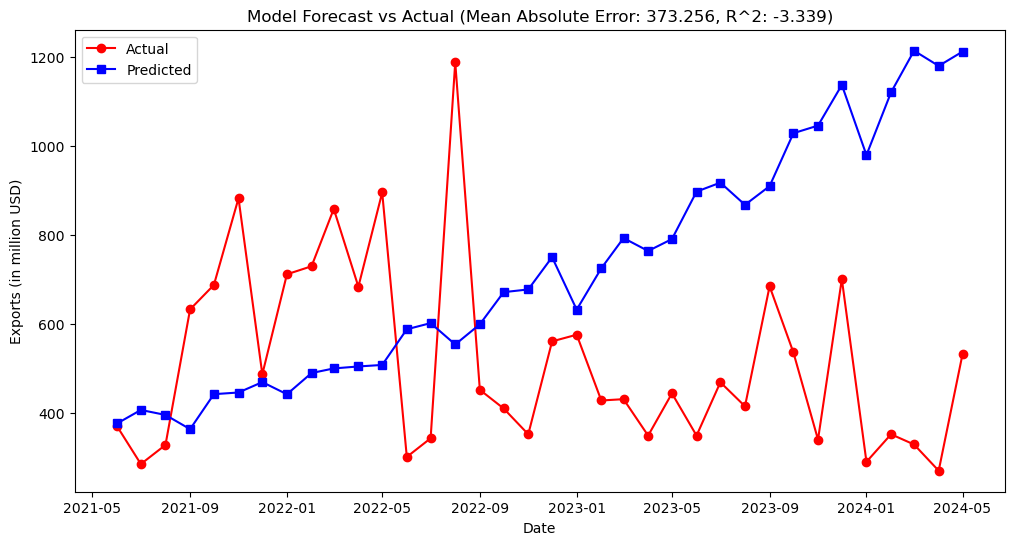

In [52]:
actual = data['Value'].iloc[-n:] 
evaluate_model(actual, reseasonalised_forecast)

### Final Code<a id="section8"></a>

In [54]:
def train_and_forecast(data, forecast_length):
    # Data Preparation
    print("\nRaw Filtered Data:")
    data = preprocess(data)
    print(data)

    # Visualise Time Series
    print("\nVisualising data against time:")
    visualise_timeseries(data)

    # Decompose Time Series
    print("\nDecomposition of time series:")
    trend, seasonal, residual = decomposition(data)
    
    # Remove seasonal component to de-seasonalize
    df = deseasonalise(data)
    
    # Calculate percentage change
    df = cal_percentage_change(df)
    
    # Perform stationarity tests on percentage change
    print("\nStationarity tests on percentage change:")
    perform_stationarity_tests(df['Pct_change'])
    
    # First-order differencing on percentage change
    df = differencing(df)
    
    # Perform stationarity tests on differenced data
    print("\nStationarity tests after first-order differencing:")
    perform_stationarity_tests(df['Pct_change_Diff'])

    print("\nData to be used for modelling:")
    print(df)
    
    # Plot ACF and PACF for differenced data
    plot_acf_pacf(df['Pct_change_Diff'])

    # Create dataframe for modelling based on pct_change_diff
    model_data = df['Pct_change_Diff'].dropna()
    model_data = model_data.to_frame(name = 'Pct_change_Diff')
    model_data.index = pd.to_datetime(model_data.index)
    model_data = model_data.asfreq('MS')
    
    # Split into train and test sets
    X = model_data.values
    n = forecast_length
    size = len(X) - n
    train, test = X[0:size], X[size:len(X)]

    # ARIMA Model on De-seasonalized Differenced Data
    print("Training ARIMA Model...")
    arima_predictions = rolling_walk_forward(train, build_arima_model, forecast_with_arima, n)
    
    # Adjust predictions back to original scale by obtaining price form and reseasonalising by multiplying seasonal component
    last_pct_change = df['Pct_change'].iloc[-n-1] # last known percentage change is at the 37th (-n-1) position from the back
    pct_changes = revert_differencing(last_pct_change, arima_predictions) # obtaining value in pct change by reverting from pct change diff
    print(pct_changes)
            
    last_known_value = df['Value'].iloc[-n-1] # last known value inprice form  is at the 37th (-n-1) position from the back
    price_form = revert_pct_change(last_known_value, pct_changes) # obtaining value in price form by reverting from pct change
    print(price_form)
        
    reseasonalised_forecast = price_form * seasonal[-n:] # obtaining value in reseasonalised price form by multiplying with seasonal component of those months
    print(reseasonalised_forecast)
    
    # Evaluate the model
    actual = data['Value'].iloc[-n:]
    evaluate_model(actual, reseasonalised_forecast)



Raw Filtered Data:
             Value
Time Period       
1997-01-01   109.0
1997-02-01    98.0
1997-03-01    90.0
1997-04-01   101.0
1997-05-01   118.0
...            ...
2024-01-01   290.0
2024-02-01   352.0
2024-03-01   329.0
2024-04-01   270.0
2024-05-01   532.0

[329 rows x 1 columns]

Visualising data against time:


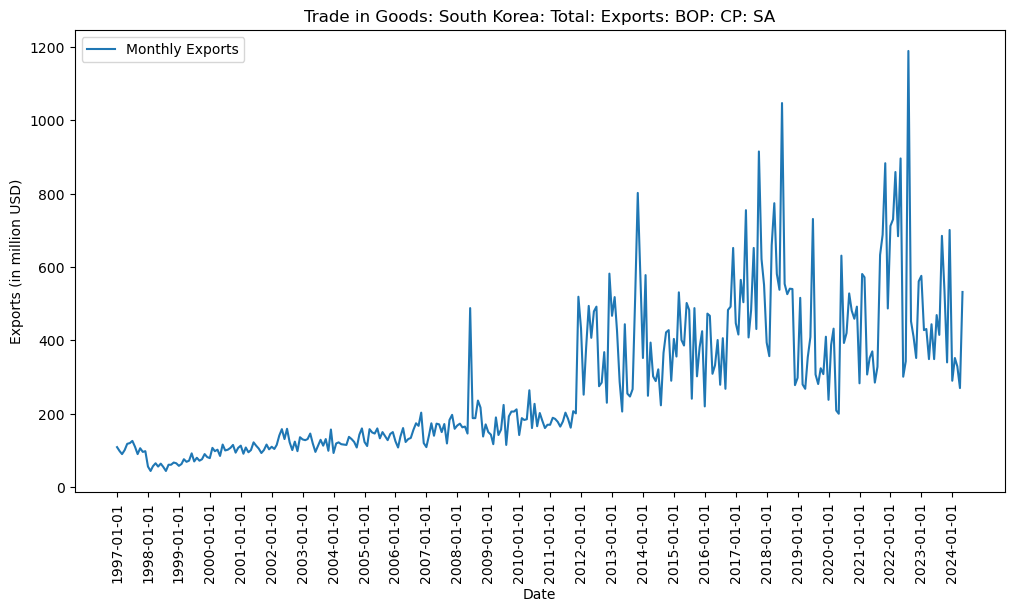


Decomposition of time series:


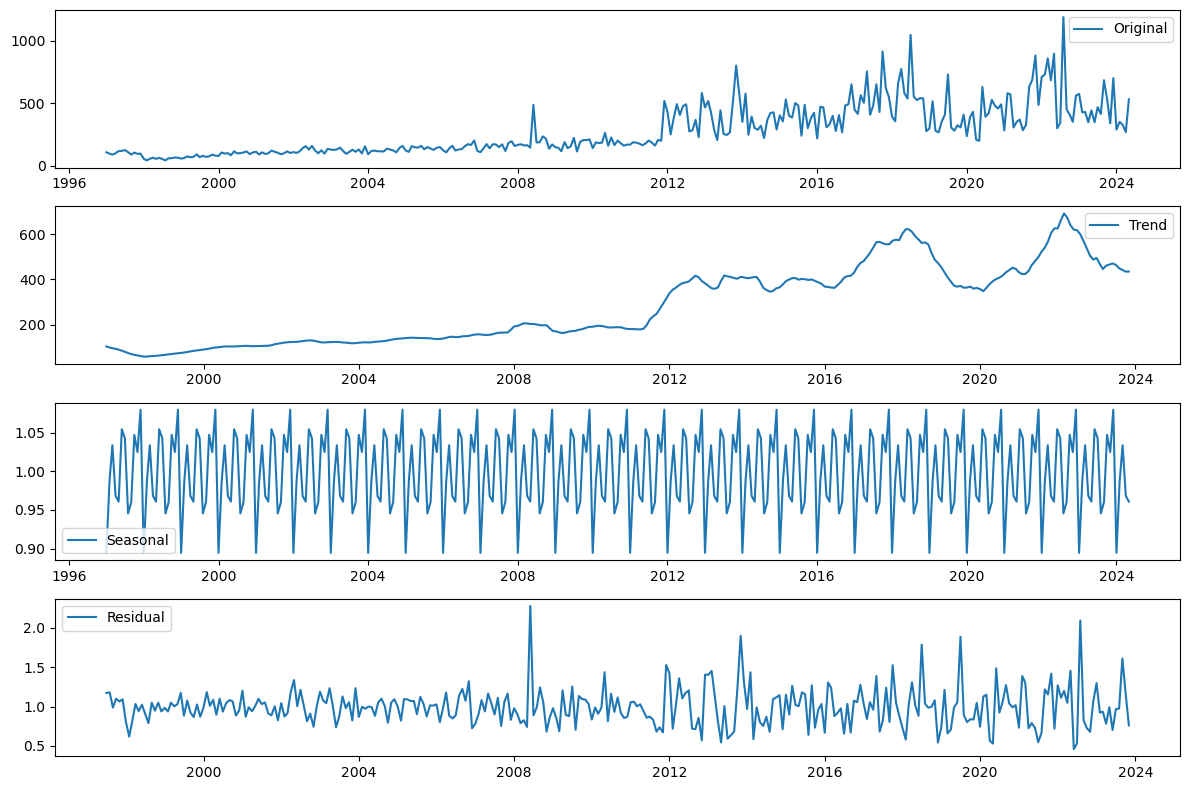

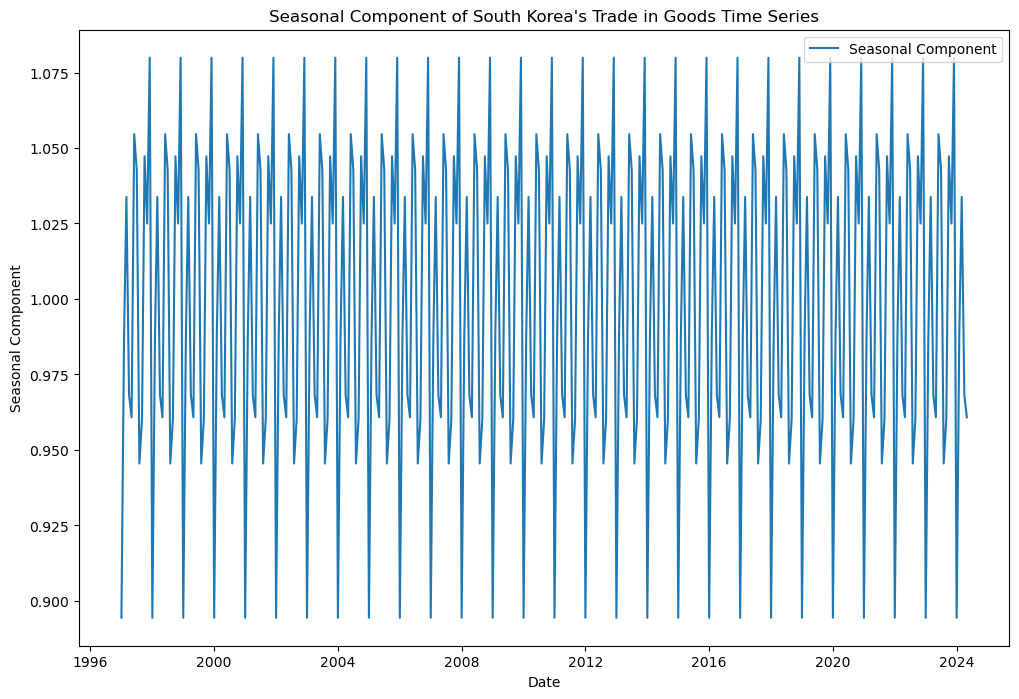

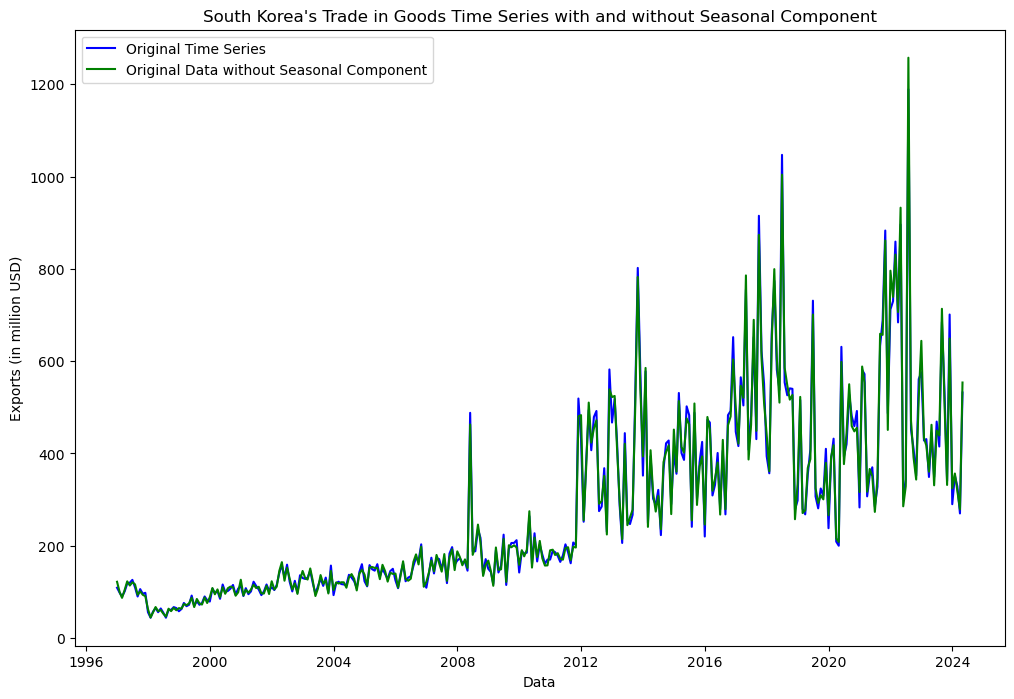


Stationarity tests on percentage change:
ADF Statistic: -12.190829111445796
p-value: 1.2869516713121955e-22
Critical Values:
   1%, -3.450695263332383
Critical Values:
   5%, -2.87050218926466
Critical Values:
   10%, -2.5715449066453284

KPSS Statistic: 1.0454362080799753
p-value: 0.01
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739

Stationarity tests after first-order differencing:
ADF Statistic: -9.088554994428192
p-value: 3.8800657076006085e-15
Critical Values:
   1%, -3.451552879535732
Critical Values:
   5%, -2.8708786756338407
Critical Values:
   10%, -2.571745666091128

KPSS Statistic: 0.07922086727643882
p-value: 0.1
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739

Data to be used for modelling:
                  Value  Pct_change  Pct_change_Diff
Time Period                                         
1997-03-01    87.057439   -0

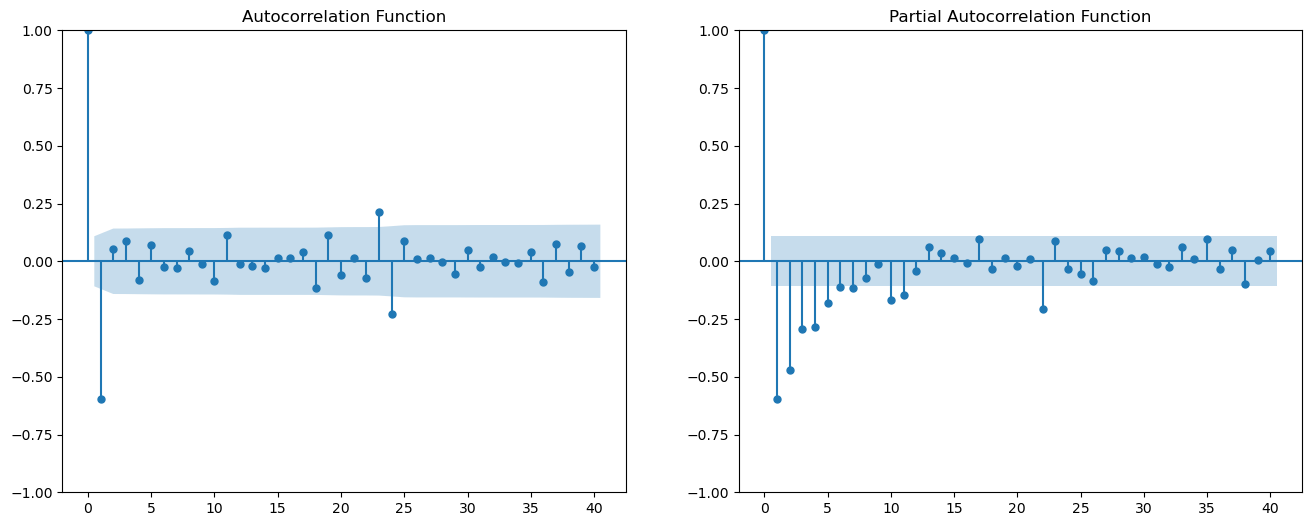

Training ARIMA Model...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=855.327, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=649.410, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=853.328, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=508.512, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=451.126, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=407.759, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=360.241, Time=0.06 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=346.133, Time=0.07 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=323.411, Time=0.09 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=309.258, Time=0.15 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=305.229, Time=0.21 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=303.447, Time=0.23 sec
 ARIMA(10,1,1)(0,0,0)[0] inter

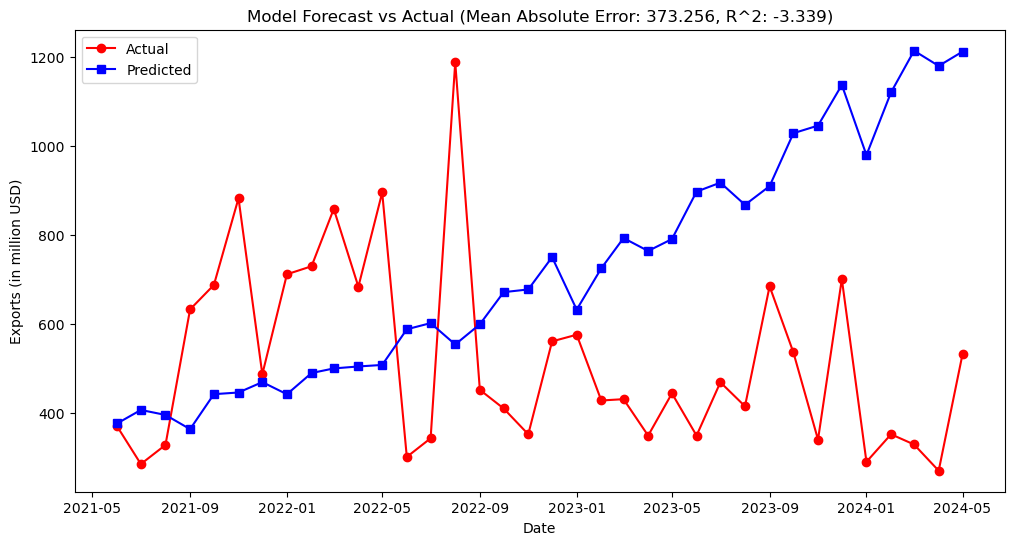

In [55]:
data = load_data('series-270724.csv')
train_and_forecast(data, 36)

### Alternative Modelling<a id="section9"></a>

##### ARIMA Modelling on abs(Pct_change)<a id="subsection9.1"></a>

Based on the performance of the ARIMA model above, alternative models should be considered to analyse the data. One possible alternative is to build the ARIMA model with respect to abs(Pct_change) instead of Pct_change. By taking the absolute value of Pct_change, it removes the ‘directional’ (ie. positive or negative) component of the data and solely focuses on the amplitude of change month on month. The hypothesis is that this alternate ARIMA model is more accurate in predicting future values than the above ARIMA model.

In [59]:
# obtaining dataframe of percentage changes in absolute values

df1 = abs(df['Pct_change']).dropna()
df1 = df1.to_frame(name = 'Pct_change')
df1.index = pd.to_datetime(df1.index)
df1 = df1.asfreq('MS')

print(df1)

             Pct_change
Time Period            
1997-03-01     0.122733
1997-04-01     0.198215
1997-05-01     0.177313
1997-06-01     0.073444
1997-07-01     0.061893
...                 ...
2024-01-01     0.500535
2024-02-01     0.099384
2024-03-01     0.107170
2024-04-01     0.123759
2024-05-01     0.985543

[327 rows x 1 columns]


In [60]:
perform_stationarity_tests(df1['Pct_change'])

ADF Statistic: -16.10816968120676
p-value: 5.0464726475342636e-29
Critical Values:
   1%, -3.4505694423906546
Critical Values:
   5%, -2.8704469462727795
Critical Values:
   10%, -2.5715154495841017

KPSS Statistic: 2.910591486998558
p-value: 0.01
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739


In [61]:
# differencing the percentage change to get pct_change_diff
df1 = differencing(df1)
print(df1)

             Pct_change  Pct_change_Diff
Time Period                             
1997-04-01     0.198215         0.075482
1997-05-01     0.177313        -0.020901
1997-06-01     0.073444        -0.103870
1997-07-01     0.061893        -0.011551
1997-08-01     0.037198        -0.024695
...                 ...              ...
2024-01-01     0.500535        -0.456426
2024-02-01     0.099384        -0.401151
2024-03-01     0.107170         0.007786
2024-04-01     0.123759         0.016588
2024-05-01     0.985543         0.861784

[326 rows x 2 columns]


In [62]:
perform_stationarity_tests(df1['Pct_change_Diff'])

ADF Statistic: -7.837240276531721
p-value: 6.0690060077937106e-12
Critical Values:
   1%, -3.45176116018037
Critical Values:
   5%, -2.870970093607691
Critical Values:
   10%, -2.571794416006072

KPSS Statistic: 0.12903017227118063
p-value: 0.1
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739


In [63]:
# Create dataframe for modelling based on pct_change_diff
model_data1 = df1['Pct_change_Diff'].dropna()
model_data1 = model_data1.to_frame(name = 'Pct_change_Diff')
model_data1.index = pd.to_datetime(model_data1.index)
model_data1 = model_data1.asfreq('MS')
    
# Split into train and test sets
forecast_length = 36
Y = model_data1.values
m = forecast_length    
size1= len(Y) - m
train1, test1 = Y[0:size1], Y[size1:len(Y)]

print(model_data1)
print(size1, m, len(Y))

             Pct_change_Diff
Time Period                 
1997-04-01          0.075482
1997-05-01         -0.020901
1997-06-01         -0.103870
1997-07-01         -0.011551
1997-08-01         -0.024695
...                      ...
2024-01-01         -0.456426
2024-02-01         -0.401151
2024-03-01          0.007786
2024-04-01          0.016588
2024-05-01          0.861784

[326 rows x 1 columns]
290 36 326


In [64]:
arima_predictions1 = rolling_walk_forward(train1, build_arima_model, forecast_with_arima, m)
print(arima_predictions1)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=524.272, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=371.955, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=522.273, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=321.130, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=277.913, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=224.253, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=195.059, Time=0.05 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=186.115, Time=0.08 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=165.970, Time=0.10 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=165.828, Time=0.15 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=152.592, Time=0.18 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=143.289, Time=0.31 sec
 ARIMA(10,1,1)(0,0,0)[0] intercept   : AIC=72.027, Tim

In [65]:
last_pct_change1 = df1['Pct_change'].iloc[-m-1] # last known percentage change is at the 37th (-m-1) position
pct_changes1 = revert_differencing(last_pct_change1, arima_predictions1) # obtaining value in pct change by reverting from pct change diff
print(pct_changes1)

[0.29903397942177146, 0.26508639537920664, 0.22108768802569723, 0.23134783121329847, 0.25491421627966815, 0.23900843365921004, 0.42076094317349055, 0.21795987271801304, 0.27584478703252363, 0.25090551974971453, 0.249173988883382, 0.28037592482333157, 0.23048564541566208, 0.25382042688609235, 0.27728108249069167, 0.258002010846778, 0.29985259290124455, 0.26074015118557214, 0.26357833787347756, 0.2664274995122302, 0.26134391072760693, 0.2733438798995186, 0.2651466260329345, 0.2632449697015666, 0.2752585801391239, 0.2769376108702244, 0.2780623934045562, 0.27228517533776636, 0.26821122345658654, 0.2721324269846913, 0.2719613553957769, 0.27404987334667485, 0.2738015948163808, 0.2734461554900579, 0.27602685159543916, 0.2774354478033469]


In [66]:
def evaluate_model1(actual, predictions):
    mae = mean_absolute_error(actual, predictions) # determining mean absolute error
    r2 = r2_score(actual, predictions) # determining r^2 value
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual.values, 'o-', color='red', label='Actual')
    plt.plot(actual.index, predictions, 's-', color='blue', label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change')
    plt.title(f'Model Forecast vs Actual (Mean Absolute Error: {mae:.3f}, R^2: {r2:.3f})')
    plt.legend()
    plt.show()

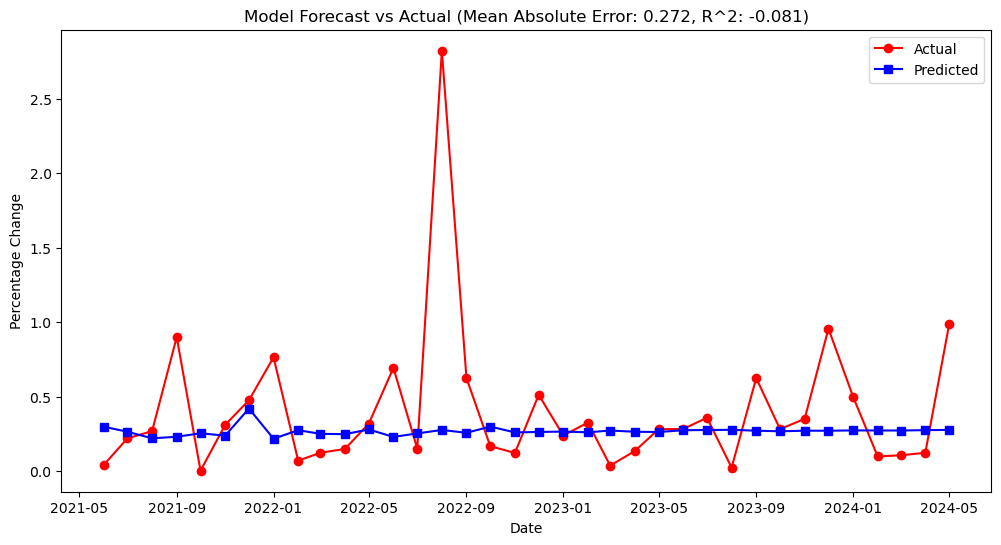

In [67]:
test1 = df1['Pct_change'].iloc[-m:] 
evaluate_model1(test1, pct_changes1)

##### Simple Regression Model<a id="subsection9.2"></a>

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [70]:
def create_lagged_feature(data):
    data['Pct_change_Lag1'] = data['Pct_change'].shift(1)
    data = data.dropna()  # Drop rows with NaN values generated by lagging
    return data

In [71]:
def split_data(data):
    X = data[['Pct_change_Lag1']]
    y = data['Pct_change']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Shuffle=False to maintain time order
    return X_train, X_test, y_train, y_test

In [72]:
def train_regression_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

In [73]:
def make_predictions(model, X_test):
    predictions = model.predict(X_test)
    return predictions

In [74]:
def evaluate_model(y_test, predictions):
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f'Mean Absolute Error: {mae:.3f}')
    print(f'R-squared: {r2:.3f}')
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, 'o-', color='red', label='Actual')
    plt.plot(y_test.index, predictions, 's-', color='blue', label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change')
    plt.title(f'Regression Predicted vs Actual (Mean Absolute Error: {mae:.3f}, R^2: {r2:.3f})')
    plt.legend()
    plt.show()

Mean Absolute Error: 0.363
R-squared: 0.055


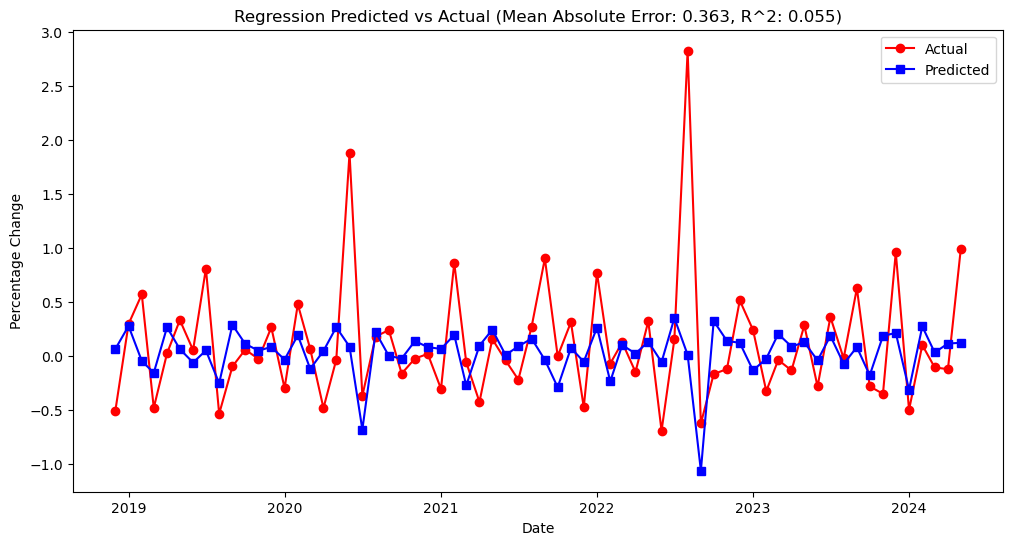

In [75]:
# Calculate percentage change and create lagged feature
df2 = cal_percentage_change(deseasonalise(data))
df2 = create_lagged_feature(df2)

# Split data into training and test sets
X_train, X_test, y_train, y_test = split_data(df2)

# Train the regression model
model = train_regression_model(X_train, y_train)

# Make predictions
predictions = make_predictions(model, X_test)

# Evaluate the model
evaluate_model(y_test, predictions)